# Doc2vec approach (31ST December 2021)

TThis notebook applies word2vec to the corpus of tribunal decisions.

In particular, the notebook does:

1. Data preparation for word2vec.

2. Implementation of word2vec averaged per document (FULL TEXT of the decision).

3. Implementation of word2vec averaged per document (ONLY JUDGEMENT TEXT).

4. Implementation of doc2vec.

This notebook should run in the tfm environment, which can be created with the environment.yml file.

In [6]:
import ipykernel
from os import listdir
from os.path import isfile, join, getsize
import numpy as np
import time
import re
import json
import pickle
import pandas as pd
import sys
import datetime
from tqdm import tqdm

import multiprocessing
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import remove_stopwords

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import sys
IN_COLAB = 'google.colab' in sys.modules


# What environment am I using?
print(f'Current environment: {sys.executable}')

# Change the current working directory
os.chdir('/Users/albertamurgopacheco/Documents/GitHub/TFM')
# What's my working directory?
print(f'Current working directory: {os.getcwd()}')


Current environment: /Users/albertamurgopacheco/anaconda3/envs/tfm/bin/python
Current working directory: /Users/albertamurgopacheco/Documents/GitHub/TFM


In [7]:
# Define working directories in colab and local execution

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    docs_path = '/content/gdrive/MyDrive/TFM/data/raw'
    input_path = '/content/gdrive/MyDrive/TFM'
    output_path = '/content/gdrive/MyDrive/TFM/output'

else:
    docs_path = './data/raw'
    input_path = '.'
    output_path = './output'

# DOC2VEC: PARTIAL & FULL TEXT OF THE RULING

# 1. The data and functions needed for the averaged word2vec and the doc2vec

Removing two corrupt files from the corpus.



In [8]:
# Open jsonDataFinal file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# List to store the judicial decisions
corpus = []

# Search data list of dictionaries for dict where {"File":} = file_name
for d in tqdm(data):
    # Get the string of the decision
    doc = d.get('String')
    #dec = d.get('Decision:')
    #dec_label = d.get('Decision label:')
    if doc:
        corpus.append(doc)
        #decisions.append(dec)
        #decisions_labels.append(dec_label)
    else:
        continue

print(f'The corpus includes {len(corpus)} documents.')
#print(f'The number of documents with a decision: {len(decisions)}.')
#print(f'The number of decisions with a label: {len(decisions_labels)} documents.')

print(f'The documents are of type: {type(corpus[0])}.')

100%|██████████| 35305/35305 [00:00<00:00, 212414.83it/s]

The corpus includes 35305 documents.
The documents are of type: <class 'str'>.


The text of the decisions (and the labels) is clean. It was cleaned during the information extraction process because the exctraction required tokenization (stanza). The text of the strategies (corpus) needs to be cleaned.

In [9]:
# Gensim-implemented filters for preprocessing data
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, 
strip_multiple_whitespaces, strip_non_alphanum, strip_numeric, remove_stopwords]

# List storing the preprocessed documents
corpus_clean = [preprocess_string(doc, CUSTOM_FILTERS) for doc in corpus]

len(corpus_clean)

Some functions:

In [11]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding
    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features


def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

# 2. AVERAGED WORD2VEC ON FULL TEXT

The strategy consists on training a word2vec model using the entire text of all the 35305 rulings. The results are averaged per document. Clustering algorithms are used to identify types of documents and their topics. 

In [100]:
# Number of available cores
cores = multiprocessing.cpu_count()

# Set up the parameters of the model one-by-one. The model uninitialized
w2v_model_nocolloc = Word2Vec(min_count = 20,
                     window = 3,
                     vector_size = 300,
                     sample = 1e-5, 
                     alpha = 0.03, 
                     min_alpha = 0.0007, 
                     negative = 20,
                     workers = cores-1)

# Builds the vocabulary from a sequence of sentences. The model is initialized
w2v_model_nocolloc.build_vocab(corpus_clean, progress_per = 10000)

# Training the model
w2v_model_nocolloc.train(corpus_clean, total_examples = w2v_model_nocolloc.corpus_count, epochs = 30, report_delay = 1)

# Not plan to train the model any further. Calling init_sims(), which will make the model much more memory-efficient
w2v_model_nocolloc.init_sims(replace = True)

# Saving the model for later use
w2v_model_nocolloc.save('./output/gensim-model-corpus-nocolloc')

/var/folders/_7/fl0v9rpx6zg6s4j03vcw0fc40000gn/T/ipykernel_59720/3341728831.py:21: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model_nocolloc.init_sims(replace = True)


In [123]:
# Number of processing cores
cores = multiprocessing.cpu_count()

# Instantiate the model
w2v_model_nocolloc = Word2Vec(min_count = 20,
                     window = 3,
                     vector_size = 300,
                     sample = 1e-5,
                     alpha = 0.03,
                     min_alpha = 0.0007,
                     negative = 20,
                     workers = cores-1)

# Load the model = Word2Vec.load('./output/gensim-model-All')
model_nocolloc = Word2Vec.load('./output/gensim-model-corpus-nocolloc')

# Vectorize the judgements
vectorized_docs = vectorize(corpus_clean, model = model_nocolloc)
len(vectorized_docs), len(vectorized_docs[0])

(35305, 300)

In [141]:
# Create dataframe with the vectorizations
df_pca = pd.DataFrame(vectorized_docs)

#
pca = PCA(n_components = 3)
pca_result = pca.fit_transform(df_pca.values)
df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1] 
df_pca['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.40475541 0.16316254 0.07476259]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

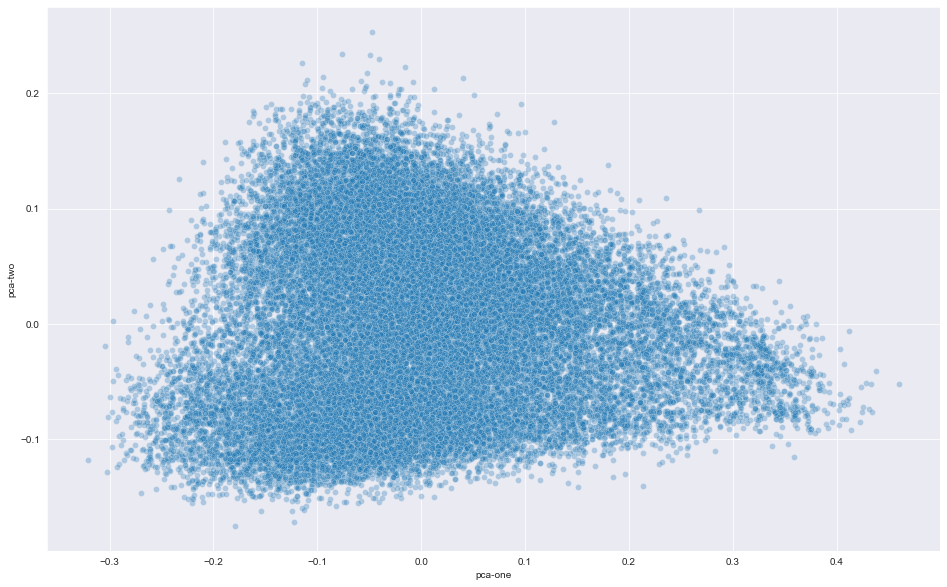

In [142]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "pca-one", y = "pca-two",
    palette = sns.color_palette("hls", 3),
    data = df_pca,
    legend = "full",
    alpha = 0.3
)

# 2.1 Visualization of PCA

In [143]:
print(df_pca.shape)

# Open jsonData file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# Create dataframe
df_labels = pd.DataFrame(data)

# Select the needed columns
df_labels = df_labels[['Decision:', 'Decision label:', 'Code label:']]

# Add labels to df
labels_col = df_labels['Decision label:']
judgement_col = df_labels['Decision:']
code_col = df_labels['Code label:']

df_pca = df_pca.join(labels_col)
df_pca = df_pca.join(code_col)

#df = df.join(judgement_col)
df_pca

(35305, 303)


0         1         2         3         4         5         6  \
0      0.019913  0.022759  0.009246 -0.038848  0.026236  0.052237  0.004463   
1      0.008893  0.012514 -0.003385 -0.008179  0.017124  0.032232 -0.015659   
2      0.015334  0.002230  0.017875 -0.022293  0.028335  0.037047  0.007844   
3     -0.000042  0.000387 -0.003050 -0.028683  0.029158  0.054178  0.006071   
4      0.005350  0.014548  0.001209 -0.026236  0.023689  0.061338  0.010520   
...         ...       ...       ...       ...       ...       ...       ...   
35300 -0.001079  0.018475  0.005432 -0.002167 -0.010644 -0.006411 -0.008876   
35301  0.000783 -0.004963  0.002879 -0.014551  0.016007  0.031826 -0.010374   
35302  0.009836  0.012867  0.014429 -0.027498  0.007029  0.032567  0.004687   
35303 -0.005959 -0.026188  0.003194 -0.002309  0.004980  0.000228 -0.012367   
35304  0.011165  0.008627  0.009075 -0.013784 -0.001979  0.011384 -0.006414   

              7         8         9  ...       295       296       297  \
0     -0.033795 -0.014397  0.014821  ...  0.018970  0.000444 -0.008727   
1     -0.031624 -0.001969  0.014466  ...  0.010760  0.002883 -0.009850   
2     -0.022269 -0.001400  0.008758  ...  0.008010 -0.011581 -0.001839   
3     -0.021987 -0.005690  0.024028  ...  0.014541 -0.001873 -0.004551   
4     -0.036129 -0.000419  0.015912  ...  0.016376 -0.006837 -0.016513   
...         ...       ...       ...  ...       ...       ...       ...   
35300 -0.018101 -0.008072  0.004903  ...  0.005685  0.002759 -0.000753   
35301 -0.028127  0.011183  0.016791  ...  0.023771  0.009412 -0.000176   
35302 -0.028525 -0.002826  0.006658  ...  0.017338  0.004517  0.001861   
35303 -0.007361  0.010187  0.011346  ...  0.002365 -0.006067  0.005392   
35304 -0.019743  0.009248  0.010605  ...  0.007648 -0.004074  0.004806   

            298       299   pca-one   pca-two  pca-three  Decision label:  \
0     -0.023895 -0.028880  0.027182  0.084375  -0.029194         Accepted   
1     -0.015316 -0.002860 -0.108266  0.059673   0.069905         Rejected   
2      0.003867 -0.026491 -0.120901  0.006326  -0.082560         Rejected   
3     -0.030424 -0.036798  0.026380 -0.093374   0.000385         Accepted   
4     -0.013300 -0.030822 -0.024011  0.044267  -0.038459         Accepted   
...         ...       ...       ...       ...        ...              ...   
35300 -0.027876  0.007539 -0.164676  0.055114  -0.006065         Accepted   
35301 -0.011016 -0.005139 -0.116211 -0.076117   0.023787         Rejected   
35302 -0.027633 -0.015424 -0.033590  0.085533  -0.096183         Rejected   
35303 -0.002041  0.003181 -0.243487 -0.086952   0.029743         Accepted   
35304 -0.012789 -0.001757 -0.147986 -0.000297  -0.064547              NaN   

       Code label:  
0               HU  
1               JR  
2               PA  
3               PA  
4               EA  
...            ...  
35300           NA  
35301           NA  
35302           NA  
35303           NA  
35304           NA  

[35305 rows x 305 columns]

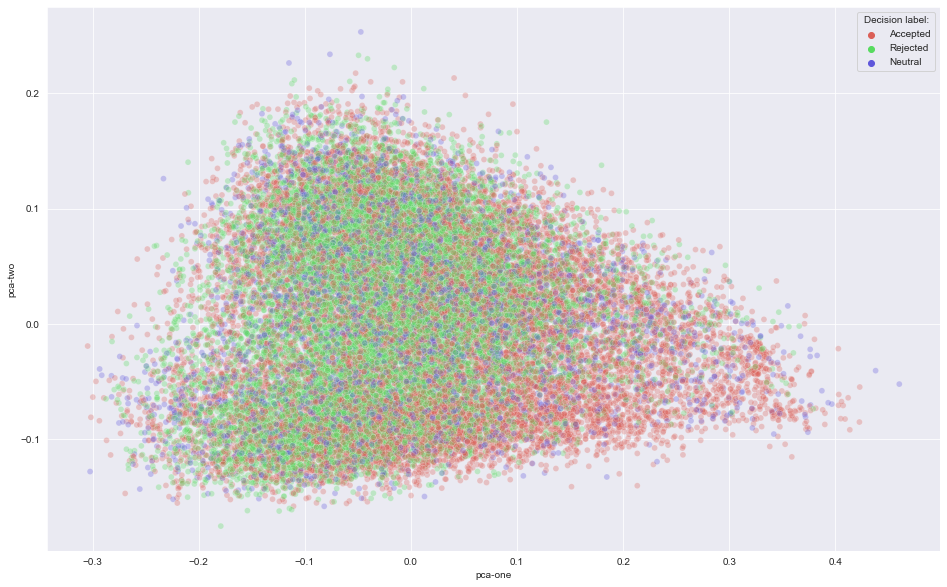

In [146]:
plt.figure(figsize = (16,10))
sns.scatterplot(
    x = 'pca-one', y = 'pca-two',
    palette = sns.color_palette('hls', 3),
    hue = 'Decision label:',
    data = df_pca,
    legend = 'full',
    alpha = 0.3
)
plt.savefig('./output/pac2.png')

/var/folders/_7/fl0v9rpx6zg6s4j03vcw0fc40000gn/T/ipykernel_59720/1048539811.py:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['Accepted' 'Rejected' 'Rejected' ... 'Rejected' 'Accepted' nan]

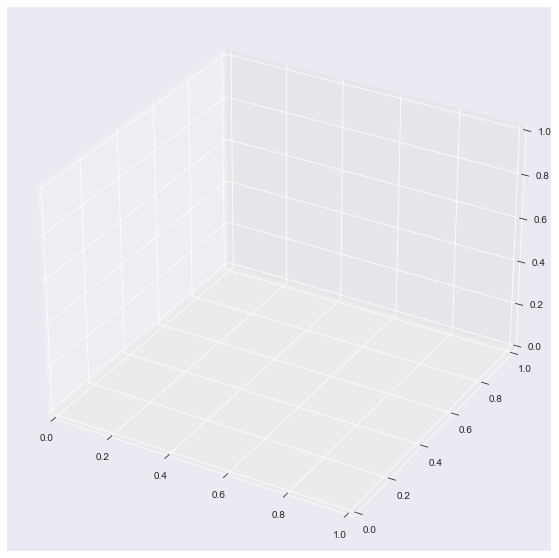

In [183]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs = df_pca["pca-one"], 
    ys = df_pca["pca-two"], 
    zs = df_pca["pca-three"], 
    c = df_pca["Decision label:"], 
    cmap = 'tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

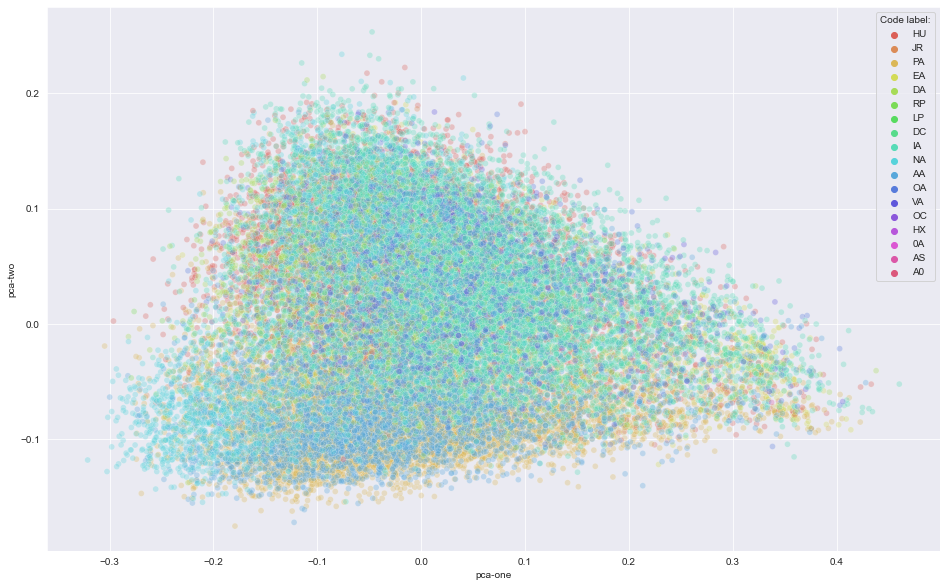

In [144]:
plt.figure(figsize = (16,10))
sns.scatterplot(
    x = "pca-one", y = "pca-two",
    palette = sns.color_palette("hls", 18),
    hue = 'Code label:',
    data = df_pca,
    legend = "full",
    alpha = 0.3
)
plt.savefig('./output/pac2_code.png')

# 2.2 Visualization of TSNE

In [154]:
# Create dataframe with vectorizations
df_tsne = pd.DataFrame(vectorized_docs)
df_tsne

tsne = TSNE(n_components = 3, verbose = 1, perplexity = 5, n_iter = 4000)
tsne_results = tsne.fit_transform(df_tsne.values)


/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 35305 samples in 0.002s...
[t-SNE] Computed neighbors for 35305 samples in 22.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 35305
[t-SNE] Computed conditional probabilities for sample 2000 / 35305
[t-SNE] Computed conditional probabilities for sample 3000 / 35305
[t-SNE] Computed conditional probabilities for sample 4000 / 35305
[t-SNE] Computed conditional probabilities for sample 5000 / 35305
[t-SNE] Computed conditional probabilities for sample 6000 / 35305
[t-SNE] Computed conditional probabilities for sample 7000 / 35305
[t-SNE] Computed conditional probabilities for sample 8000 / 35305
[t-SNE] Computed conditional probabilities for sample 9000 / 35305
[t-SNE] Computed conditional probabilities for sample 10000 / 35305
[t-SNE] Computed conditional probabilities for sample 11000 / 35305
[t-SNE] Computed conditional probabilities for sample 12000 / 35305
[t-SNE] Computed conditional probabilities for sa

In [155]:
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]

# Add labels to df
labels_col = df_labels['Decision label:']
judgement_col = df_labels['Decision:']
code_col = df_labels['Code label:']

df_tsne = df_tsne.join(labels_col)
df_tsne = df_tsne.join(code_col)

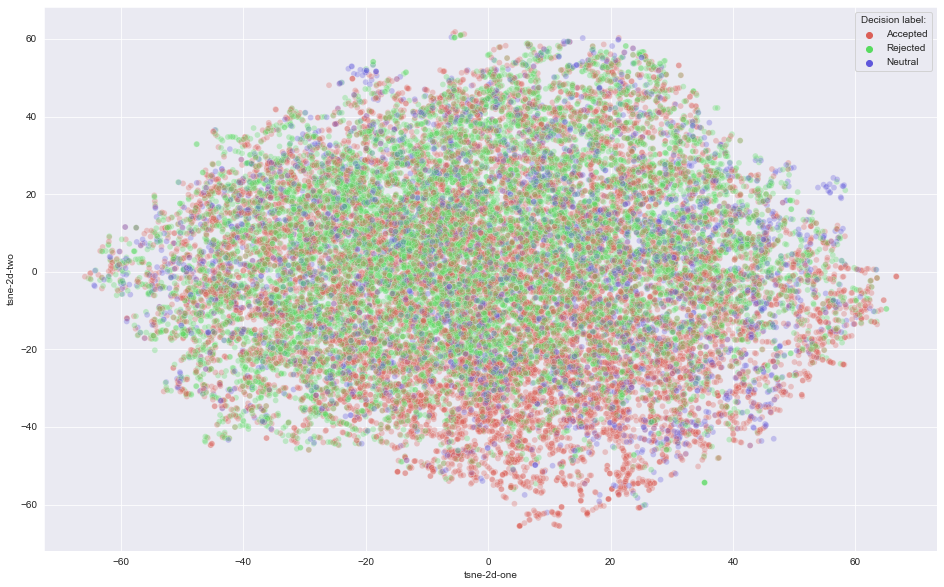

In [156]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = 'Decision label:',
    palette = sns.color_palette("hls", 3),
    data = df_tsne,
    legend = "full",
    alpha = 0.3
)
plt.savefig('./output/tsne.png')

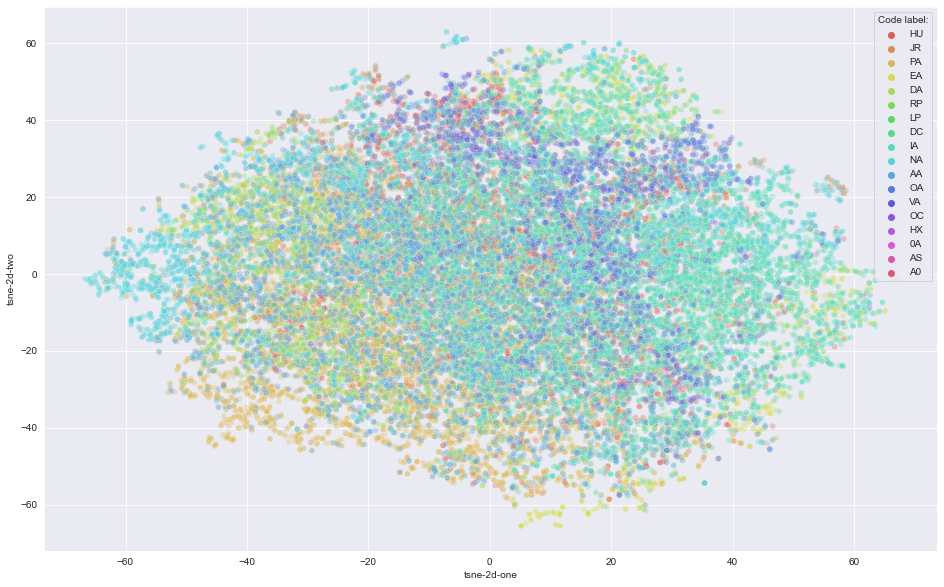

In [157]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = 'Code label:',
    palette = sns.color_palette("hls", 18),
    data = df_tsne,
    legend = "full",
    alpha = 0.3
)
plt.savefig('./output/tsne_code.png')

# 2.3 PCA and tsne visualizations side by side

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

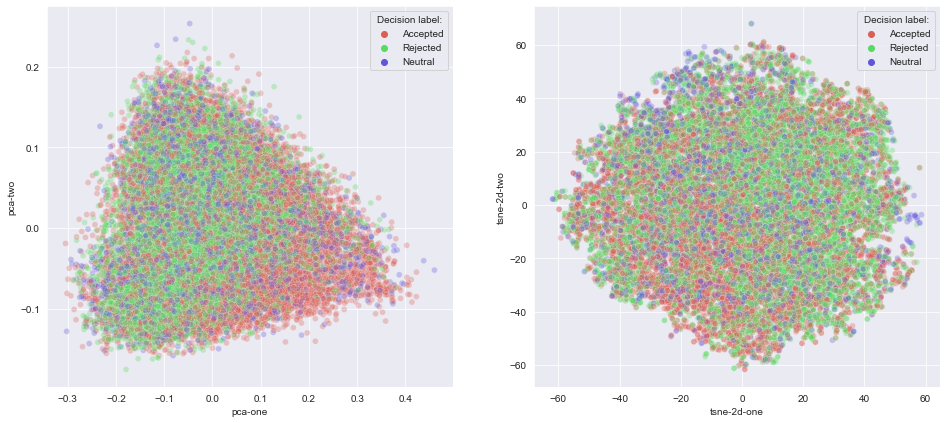

In [134]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x = "pca-one", y = "pca-two",
    hue = "Decision label:",
    palette = sns.color_palette("hls", 3),
    data = df_pca,
    legend = "full",
    alpha = 0.3,
    ax = ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x = "tsne-2d-one", y="tsne-2d-two",
    hue = 'Decision label:',
    palette = sns.color_palette("hls", 3),
    data = df_tsne,
    legend = "full",
    alpha = 0.3,
    ax = ax2
)

# 3. AVERAGED WORD2VEC ON JUDGEMENT FRAGMENT

The strategy consists on training a word2vec model using ONLY the fragment of text of the judgement using the roughly 30085 rulings for which that fragment exists. The results are averaged per document. Clustering algorithms are used to identify types of documents and their topics. 

In [158]:
# Open jsonData file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# Create dataframe
df = pd.DataFrame(data)

# Select the needed columns
df = df[['Decision:', 'Decision label:']]

# Removing the missing value
df = df.dropna().reset_index(drop = True)
df.isnull().sum()

col_judgements_list = df['Decision:'].tolist()


In [159]:
# Number of processing cores
cores = multiprocessing.cpu_count()

# Instantiate the model
w2v_model = Word2Vec(min_count = 20,
                     window = 3,
                     vector_size = 300,
                     sample = 1e-5,
                     alpha = 0.03,
                     min_alpha = 0.0007,
                     negative = 20,
                     workers = cores-1)

# Load the model = Word2Vec.load('./output/gensim-model-All')
model_judgements = Word2Vec.load('./output/gensim-model-corpus_judgements')

# Vectorize the judgements
vectorized_docs = vectorize(col_judgements_list, model = model_judgements)
len(vectorized_docs), len(vectorized_docs[0])

(30085, 300)

In [160]:
# Create dataframe with the vectorizations
df_pca_judgements = pd.DataFrame(vectorized_docs)

#
pca = PCA(n_components = 3)
pca_result = pca.fit_transform(df_pca_judgements.values)
df_pca_judgements['pca-one'] = pca_result[:,0]
df_pca_judgements['pca-two'] = pca_result[:,1] 
df_pca_judgements['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.35904157 0.17102169 0.11911411]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

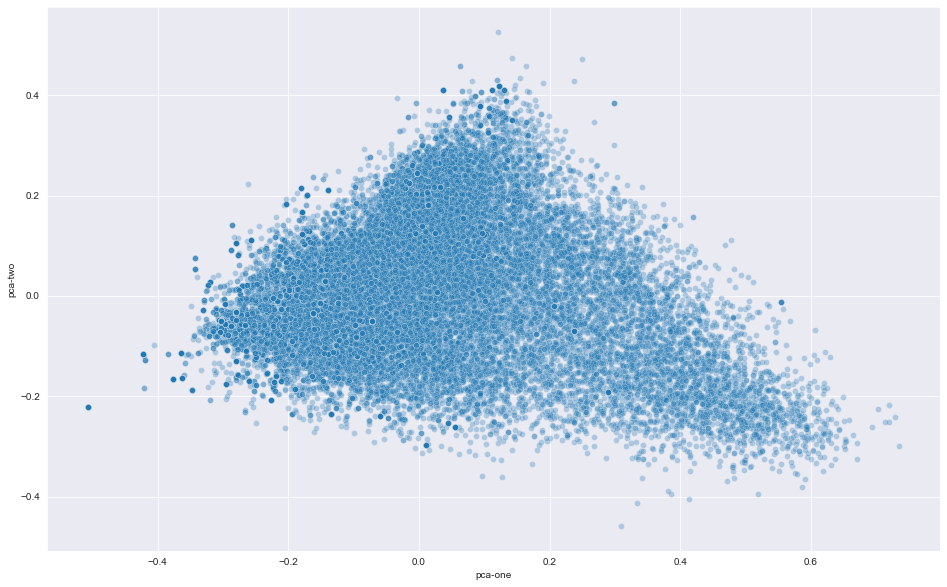

In [161]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "pca-one", y = "pca-two",
    palette = sns.color_palette("hls", 3),
    data = df_pca_judgements,
    legend = "full",
    alpha = 0.3
)

# 3.1 Visualization of PCA

In [162]:
print(df_pca_judgements.shape)

# Open jsonData file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# Create dataframe
df_labels = pd.DataFrame(data)

# Select the needed columns
df_labels = df_labels[['Decision:', 'Decision label:']]

# Add labels to df
labels_col = df_labels['Decision label:']
judgement_col = df_labels['Decision:']
  
df_pca_judgements = df_pca_judgements.join(labels_col)
df_pca_judgements = df_pca_judgements.join(judgement_col)
df_pca_judgements

(30085, 2)


0         1         2         3         4         5         6  \
0     -0.013004 -0.014020  0.045919  0.019340 -0.049135 -0.009589 -0.003350   
1      0.016931  0.025856 -0.020157 -0.009941 -0.020828 -0.018271 -0.017143   
2      0.010543 -0.019214  0.082601  0.026940 -0.064257 -0.021701  0.003173   
3      0.004191 -0.044211  0.053733  0.036051 -0.061286 -0.000244  0.013364   
4      0.024698 -0.006702  0.050285  0.038142 -0.045451 -0.014360  0.038404   
...         ...       ...       ...       ...       ...       ...       ...   
30080  0.036911  0.024113 -0.025114 -0.002925 -0.026267 -0.014781  0.044465   
30081  0.037576  0.033031 -0.013213 -0.007697 -0.003339 -0.026163  0.015091   
30082  0.029135  0.029142 -0.013293  0.009864 -0.075722  0.009931  0.044462   
30083  0.033543  0.025180  0.009124  0.004506 -0.021611 -0.016299  0.007830   
30084  0.012129  0.014127 -0.001961  0.012817 -0.006502 -0.022432  0.000067   

              7         8         9  ...       295       296       297  \
0     -0.007850 -0.030266  0.009821  ...  0.023244  0.015534  0.034305   
1     -0.010182  0.005371  0.006000  ... -0.022204 -0.010678 -0.027651   
2     -0.000630 -0.049786  0.017352  ...  0.069875  0.024055  0.053105   
3      0.006728 -0.038349  0.022128  ...  0.055242 -0.002595  0.043287   
4     -0.012002  0.004026  0.004512  ...  0.071103 -0.010259  0.028876   
...         ...       ...       ...  ...       ...       ...       ...   
30080 -0.008887 -0.010854  0.007890  ...  0.021146  0.008948  0.002575   
30081  0.009578  0.012229  0.032483  ... -0.004404 -0.001067  0.006980   
30082 -0.028397 -0.001670  0.031638  ...  0.049239  0.018838  0.000859   
30083 -0.009303  0.001598 -0.000948  ...  0.027789 -0.004259  0.029333   
30084  0.004762  0.024159  0.006623  ... -0.040690  0.007297 -0.041619   

            298       299   pca-one   pca-two  pca-three  Decision label:  \
0      0.036458 -0.022401  0.247713  0.157388   0.006063         Accepted   
1     -0.030457  0.059422  0.518170 -0.285527   0.054194         Rejected   
2      0.114811 -0.081587  0.016225  0.264302   0.051648         Rejected   
3      0.057988 -0.066420 -0.088580  0.116650  -0.094207         Accepted   
4      0.071301 -0.075486 -0.060268 -0.049821  -0.033609         Accepted   
...         ...       ...       ...       ...        ...              ...   
30080  0.044009 -0.004366  0.327339 -0.238993   0.194773         Rejected   
30081  0.001001  0.020712  0.468046 -0.204865   0.153985         Accepted   
30082  0.097191 -0.022472  0.050887 -0.119062   0.216198         Accepted   
30083  0.006755  0.029180  0.397929 -0.149640   0.135384          Neutral   
30084 -0.050091  0.053322  0.563930 -0.304017  -0.096224         Accepted   

                                               Decision:  
0      [notice, of, decision, directions, the, decisi...  
1      [in, light, of, my, conclusions, on, that, poi...  
2      [notice, of, decision, the, decision, of, the,...  
3      [notice, of, decision, the, decision, of, the,...  
4      [decision, the, decision, of, tribunal, judge,...  
...                                                  ...  
30080  [decision, the, determination, of, the, tribun...  
30081  [decision, the, decision, of, the, tribunal, c...  
30082  [it, seems, to, me, therefore, that, in, the, ...  
30083  [plainly, the, panel, was, aware, of, the, app...  
30084  [having, concluded, that, the, tribunal, erred...  

[30085 rows x 305 columns]

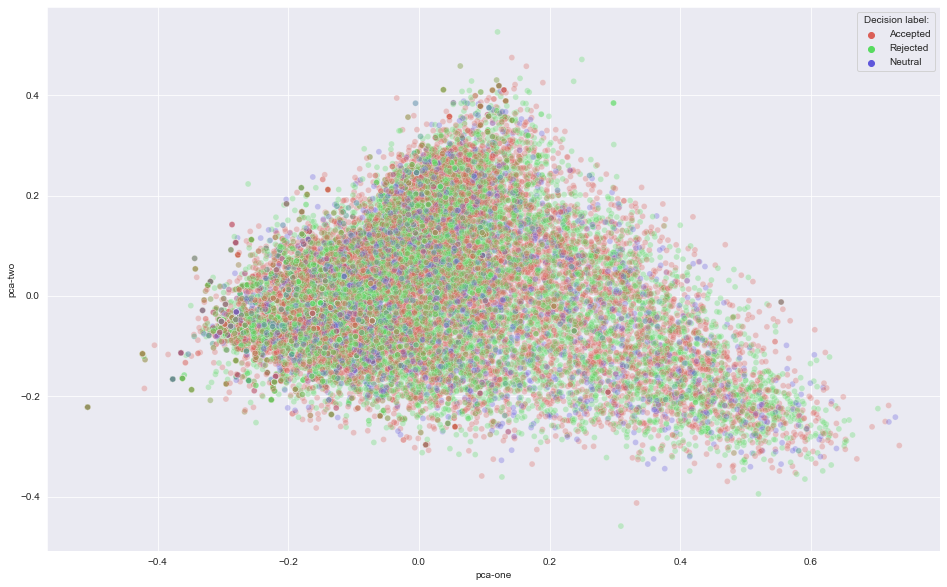

In [164]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "pca-one", y = "pca-two",
    palette = sns.color_palette("hls", 3),
    hue = 'Decision label:',
    data = df_pca_judgements,
    legend = "full",
    alpha = 0.3
)
plt.savefig('./output/pca_judgement.png')

# 3.2 Visualization of TSNE

In [166]:
# Create dataframe with vectorizations
df_tsne_judgements = pd.DataFrame(vectorized_docs)
df_tsne_judgements

tsne = TSNE(n_components = 3, verbose = 1, perplexity = 5, n_iter = 4000)
tsne_results = tsne.fit_transform(df_tsne_judgements.values)


/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/albertamurgopacheco/anaconda3/envs/tfm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 30085 samples in 0.002s...
[t-SNE] Computed neighbors for 30085 samples in 17.527s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30085
[t-SNE] Computed conditional probabilities for sample 2000 / 30085
[t-SNE] Computed conditional probabilities for sample 3000 / 30085
[t-SNE] Computed conditional probabilities for sample 4000 / 30085
[t-SNE] Computed conditional probabilities for sample 5000 / 30085
[t-SNE] Computed conditional probabilities for sample 6000 / 30085
[t-SNE] Computed conditional probabilities for sample 7000 / 30085
[t-SNE] Computed conditional probabilities for sample 8000 / 30085
[t-SNE] Computed conditional probabilities for sample 9000 / 30085
[t-SNE] Computed conditional probabilities for sample 10000 / 30085
[t-SNE] Computed conditional probabilities for sample 11000 / 30085
[t-SNE] Computed conditional probabilities for sample 12000 / 30085
[t-SNE] Computed conditional probabilities for sa

In [167]:
df_tsne_judgements['tsne-2d-one'] = tsne_results[:,0]
df_tsne_judgements['tsne-2d-two'] = tsne_results[:,1]

# Add labels to df
labels_col = df_labels['Decision label:']
judgement_col = df_labels['Decision:']
  
df_tsne_judgements = df_tsne_judgements.join(labels_col)
df_tsne_judgements = df_tsne_judgements.join(judgement_col)

#df

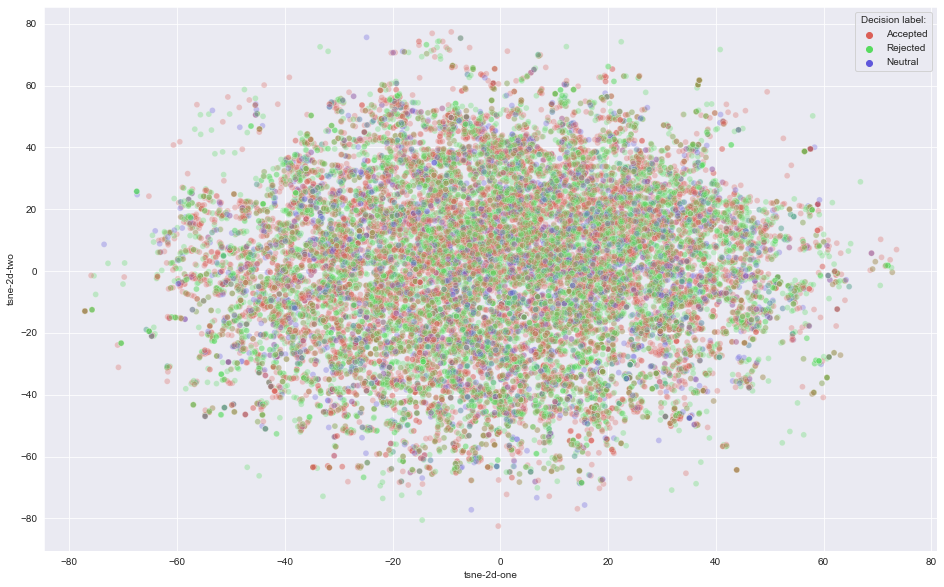

In [168]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = 'Decision label:',
    palette = sns.color_palette("hls", 3),
    data = df_tsne_judgements,
    legend = "full",
    alpha = 0.3
)
plt.savefig('./output/tsne_judgement.png')

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

<Figure size 1152x720 with 0 Axes>

# 3.3 PCA and tsne visualizations side by side

ValueError: Could not interpret value `pca-one` for parameter `x`

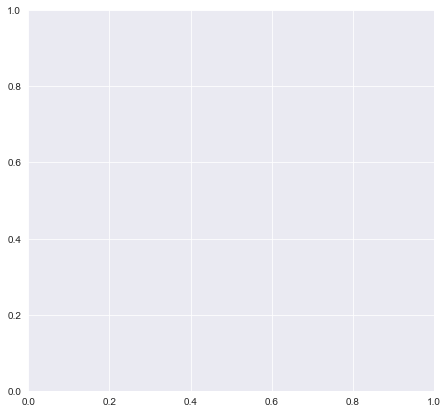

In [132]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x = "pca-one", y = "pca-two",
    hue = "Decision label:",
    palette = sns.color_palette("hls", 3),
    data = df_pca,
    legend = "full",
    alpha = 0.3,
    ax = ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_tsne,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [ ]:



def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components = 13).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress = True)
    
    Y = TSNE(n_components = 2, random_state = 0, perplexity = 15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})


    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="x", y="y",
        hue="y",
        data=df,
        legend="full",
        alpha=0.3
    )


Done

In [170]:
# Open jsonData file as data
with open('./data/jsonDataFinal.json') as json_file:
    data = json.load(json_file)

# Create df with data
df = pd.DataFrame(data)

# Replace np.nan values for empty list where no decision 
df['Decision:'] = [ [] if isinstance(x, float) else x for x in df['Decision:']]

# Original texts and labels of the decisions tokenized and ready to train a w2v
decisions = df['Decision:'].tolist()
decisions_labels = df['Decision label:'].tolist()


In [171]:


vectorized_decisions = vectorize(decisions, model = model_nocolloc)
len(vectorized_decisions), len(vectorized_decisions[0])

(35305, 300)

In [176]:


docs = df['Decision:'].tolist()
decision_labels = df['Decision label:'].tolist()


clustering, cluster_labels = mbkmeans_clusters(
	X = vectorized_decisions,
    k = 2,
    mb = 500,
    print_silhouette_values = True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in corpus_clean],
    "cluster": cluster_labels,
    "label": decision_labels
})

For n_clusters = 2
Silhouette coefficient: 0.51
Inertia:2075.8185070717827
Silhouette values:
    Cluster 1: Size:7450 | Avg:0.66 | Min:0.03 | Max: 0.83
    Cluster 0: Size:27855 | Avg:0.48 | Min:-0.05 | Max: 0.62


In [12]:
df_clusters.head(100)

text  \
0   [notice, of, decision, directions, the, decisi...   
1   [in, light, of, my, conclusions, on, that, poi...   
2   [notice, of, decision, the, decision, of, the,...   
3   [notice, of, decision, the, decision, of, the,...   
4   [decision, the, decision, of, tribunal, judge,...   
..                                                ...   
95  [decision, the, judge, materially, erred, in, ...   
96  [decision, the, judge, materially, erred, in, ...   
97  [from, the, point, at, which, the, applicant, ...   
98                                                 []   
99  [notice, of, decision, the, decision, of, the,...   

                                               tokens  cluster     label  
0   pic iac fh ck v upper tribunal immigration asy...        1  Accepted  
1   utijr jr upper tribunal immigration asylum cha...        1  Rejected  
2   pic upper tribunal immigration asylum chamber ...        0  Rejected  
3   pic upper tribunal immigration asylum chamber ...        0  Accepted  
4   pic upper tribunal immigration asylum chamber ...        0  Accepted  
..                                                ...      ...       ...  
95  pic upper tribunal immigration asylum chamber ...        0  Accepted  
96  pic upper tribunal immigration asylum chamber ...        0  Accepted  
97  upper tribunal pic jr field house breams build...        1   Neutral  
98  pic case jr v upper tribunal immigration asylu...        1       NaN  
99  pic upper tribunal immigration asylum chamber ...        0  Accepted  

[100 rows x 4 columns]

In [179]:
print("Most representative terms per cluster (based on centroids):")
for i in range(2):
    tokens_per_cluster = ""
    most_representative = model_nocolloc.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")


Most representative terms per cluster (based on centroids):
Cluster 0: decision tribunal tier appeal aside error dismiss law set allowing 
Cluster 1: decision appeal error judge accordingly set tier grounds ftt consider 


# 4. AVERAGED WORD2VEC ON TEXT OF THE RULING DESCRIBING THE DECISION

The strategy consists on training a word2vec model using the part of the text describing the judges decision from each the 35305 rulings. The results are averaged per document. Clustering algorithms are used to identify types of documents and their topics. There should be three types of documents: "Accepted", "Rejected" and "Salomonic/cannot tell".

In [4]:
# Number of processing cores
model_judgements = Word2Vec.load('./output/gensim-model-corpus_judgements')


In [5]:
clean_decisions = [x for x in decisions if x != None]

vectorized_decisions = vectorize(decisions, model = model_judgements)

len(vectorized_decisions), len(vectorized_decisions[0])

NameError: name 'decisions' is not defined

In [32]:

clustering, cluster_labels = mbkmeans_clusters(
	X = vectorized_decisions,
    k = 3,
    mb = 500,
    print_silhouette_values = True,
)
df_clusters = pd.DataFrame({
    "text": decisions,
    "tokens": [" ".join(text) for text in decisions],
    "cluster": cluster_labels,
    "label": decisions_labels
})

For n_clusters = 3
Silhouette coefficient: 0.34
Inertia:120377.10873388828
Silhouette values:
    Cluster 2: Size:9810 | Avg:0.55 | Min:0.02 | Max: 0.73
    Cluster 1: Size:4238 | Avg:0.40 | Min:-0.02 | Max: 0.57
    Cluster 0: Size:21257 | Avg:0.23 | Min:-0.12 | Max: 0.43


In [39]:
print("Most representative terms per cluster (based on centroids):")
for i in range(3):
    tokens_per_cluster = ""
    most_representative = model_judgements.wv.most_similar(positive = [clustering.cluster_centers_[i]], topn = 15)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: decision the aside set of law appeal error tribunal notice making i point involved remake 
Cluster 1: tribunal procedure direction anonymity rule unless until directs upper rules regarding otherwise the of court 
Cluster 2: the of i to aside decision appeal set it is law tribunal be that tier 


In [40]:
df_clusters

text  \
0      [notice, of, decision, directions, the, decisi...   
1      [in, light, of, my, conclusions, on, that, poi...   
2      [notice, of, decision, the, decision, of, the,...   
3      [notice, of, decision, the, decision, of, the,...   
4      [decision, the, decision, of, tribunal, judge,...   
...                                                  ...   
35300  [conclusions, a, northern, cyprus, is, not, ca...   
35301  [for, the, reasons, we, have, given, we, dismi...   
35302  [our, conclusions, on, the, general, issues, r...   
35303  [conclusions, for, each, of, the, main, reason...   
35304                                                 []   

                                                  tokens  cluster     label  
0      notice of decision directions the decision of ...        2  Accepted  
1      in light of my conclusions on that point littl...        2  Rejected  
2      notice of decision the decision of the tribuna...        1  Rejected  
3      notice of decision the decision of the tribuna...        0  Accepted  
4      decision the decision of tribunal judge malcol...        0  Accepted  
...                                                  ...      ...       ...  
35300  conclusions a northern cyprus is not capable o...        2  Accepted  
35301  for the reasons we have given we dismiss this ...        2  Rejected  
35302  our conclusions on the general issues relating...        2  Rejected  
35303  conclusions for each of the main reason a and ...        2  Accepted  
35304                                                           2       NaN  

[35305 rows x 4 columns]

doc2vec

In [19]:
from gensim.models.doc2vec import Doc2Vec

model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

NameError: name 'train_tagged' is not defined